In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import os
import shutil
import pickle
from google.colab import files 
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D  
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import tensorflow_addons as tfa
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from PIL import Image
import cv2
from tensorflow.keras.applications import ResNet50
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

from skimage import io
from skimage.transform import resize

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Init Program

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip Data

In [6]:
! unzip '/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Datasets/Rice/train-preprocess.zip' -d . 

Archive:  /content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Datasets/Rice/train-preprocess.zip
   creating: ./train-preprocess/BrownSpot/
  inflating: ./train-preprocess/BrownSpot/_0_4267.png  
  inflating: ./train-preprocess/BrownSpot/_0_9092.png  
  inflating: ./train-preprocess/BrownSpot/_1_5108.png  
  inflating: ./train-preprocess/BrownSpot/_1_8345.png  
  inflating: ./train-preprocess/BrownSpot/_1_9520.png  
  inflating: ./train-preprocess/BrownSpot/_10_1125.png  
  inflating: ./train-preprocess/BrownSpot/_10_3620.png  
  inflating: ./train-preprocess/BrownSpot/_10_6139.png  
  inflating: ./train-preprocess/BrownSpot/_100_8983.png  
  inflating: ./train-preprocess/BrownSpot/_100_9858.png  
  inflating: ./train-preprocess/BrownSpot/_101_4946.png  
  inflating: ./train-preprocess/BrownSpot/_101_9273.png  
  inflating: ./train-preprocess/BrownSpot/_102_7065.png  
  inflating: ./train-preprocess/BrownSpot/_102_7981.png  
  inflating: ./train-preprocess/BrownSpot/_

In [5]:
os.listdir('/content/drive/Shareddrives/Teman Tani/Capstone 2023')

['Teman Tani Bangkit 2023 Product-based Capstone.gdoc',
 'Machine Learning',
 'Teman Tani Schedule.gsheet',
 'Mobile']

### Supporting Function

In [ ]:
from tensorflow.keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.95:
            print("Validation accuracy reached 0.95 or higher. Stopping training.")
            self.model.stop_training = True

In [7]:
def callbacks(filename):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

  return [es, mc, reduce_lr]

In [ ]:
def predict_new_data(model, shape, path):
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())

  img = load_img(path, target_size=shape)
  imgplot = plt.imshow(img)
  target = img_to_array(img)
  target = np.expand_dims(target, axis=0)
  target = np.vstack([target])
  target /= 255
  pred = model.predict(target)
  return labels[np.argmax(pred, axis=1)[0]]

In [8]:
def save_model(name, model, model_dir):
  path = os.path.join(model_dir, name)
  if os.path.isdir(path):
    print('\nReplacing the model with the new One\n')
    shutil.rmtree(path, ignore_errors=True)

  model.save(path)
  print("Export path: ", path)
  print(os.listdir(path))

### Prepare Data

In [9]:
image_shape=255
datagen = ImageDataGenerator(
       rotation_range=40,
            width_shift_range=0.15,
            height_shift_range=0.15,
            zoom_range=0.1,
            rescale=1.0/255,
            horizontal_flip=True,
            vertical_flip=True, 
            brightness_range=[0.75,1.25], 
            validation_split=0.2
)

val_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)
batch_size = 75 #Bisa diganti2

train_generator = datagen.flow_from_directory(
    '/content/train-preprocess',
    target_size =(255,255),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    
)

validation_generator = val_datagen.flow_from_directory(
    '/content/train-preprocess',
    target_size = (255,255),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 799 images belonging to 4 classes.


In [10]:
train_generator.class_indices

{'BrownSpot': 0, 'Healthy': 1, 'Hispa': 2, 'LeafBlast': 3}

## Modelling

In [11]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

### Model 1 (Dense 121 0.84 val_acc)

In [18]:
model1 = Sequential()
model1.add(tf.keras.applications.DenseNet121(input_shape = (image_shape, image_shape, 3), include_top = False, weights = 'imagenet' ))
model1.add(GlobalAveragePooling2D())
model1.add(Dense(512, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model1.add(Dropout(0.7))
model1.add(Dense(256, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model1.add(Dropout(0.7))
model1.add(Dense(4, activation = 'softmax'))

In [19]:
model1.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [20]:
 history = model1.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_DenseNet121.h5")
                            )

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.8244 - accuracy: 0.2874
Epoch 1: val_accuracy improved from -inf to 0.27600, saving model to Model_DenseNet121.h5
42/42 [==============================] - 200s 2s/step - loss: 1.8244 - accuracy: 0.2874 - val_loss: 1.4277 - val_accuracy: 0.2760 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3054 - accuracy: 0.3987
Epoch 2: val_accuracy improved from 0.27600 to 0.30267, saving model to Model_DenseNet121.h5
42/42 [==============================] - 82s 2s/step - loss: 1.3054 - accuracy: 0.3987 - val_loss: 1.5288 - val_accuracy: 0.3027 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.1876 - accuracy: 0.4250
Epoch 3: val_accuracy improved from 0.30267 to 0.41467, saving model to Model_DenseNet121.h5
42/42 [==============================] - 81s 2s/step - loss: 1.1876 - accuracy: 0.4250 - val_loss: 1.2717 - val_accuracy: 0.4147 - lr: 2.0000e-04
Epo

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [22]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

In [23]:
y_test = validation_generator.classes
y_pred = model1.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

<ipython-input-23-1f97d7f25348>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model1.predict_generator(validation_generator)


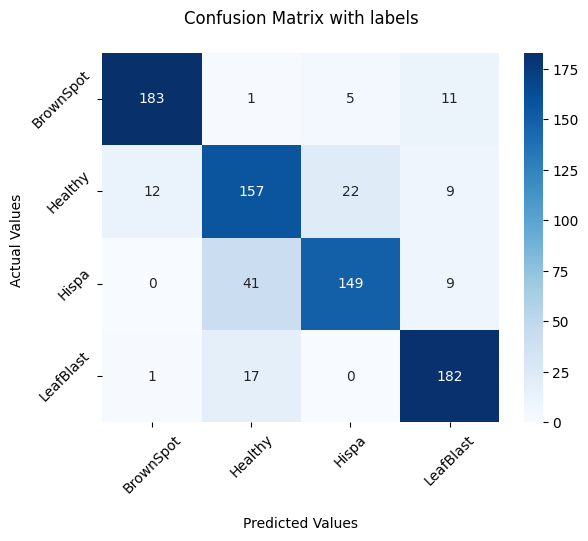

In [24]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

plt.show()

In [27]:
model = keras.models.load_model('/content/Model_DenseNet121.h5')

In [28]:
save_model("Densenet121-0.84val", model, "/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Rice/Model")

Export path:  /content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Rice/Model/Densenet121-0.84val
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


### Model 2

In [29]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 

In [33]:
model2 = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_shape=(image_shape,image_shape,3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  
])

model2.layers[0].trainable = False

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 512)               655872    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 4)                

In [34]:
model2.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [35]:
 history2 = model2.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 64,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_MobileNetV2.h5")
                            )

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.2561 - accuracy: 0.4102
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to Model_MobileNetV2.h5
42/42 [==============================] - 75s 2s/step - loss: 1.2561 - accuracy: 0.4102 - val_loss: 1.1053 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.1299 - accuracy: 0.4890
Epoch 2: val_accuracy improved from 0.50000 to 0.51333, saving model to Model_MobileNetV2.h5
42/42 [==============================] - 69s 2s/step - loss: 1.1299 - accuracy: 0.4890 - val_loss: 1.0480 - val_accuracy: 0.5133 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.0730 - accuracy: 0.5184
Epoch 3: val_accuracy did not improve from 0.51333
42/42 [==============================] - 68s 2s/step - loss: 1.0730 - accuracy: 0.5184 - val_loss: 1.0869 - val_accuracy: 0.4680 - lr: 2.0000e-04
Epoch 4/30
42/42 [============================

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [37]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

In [39]:
y_test = validation_generator.classes
y_pred = model2.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

<ipython-input-39-b6fc1ad3b738>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model2.predict_generator(validation_generator)


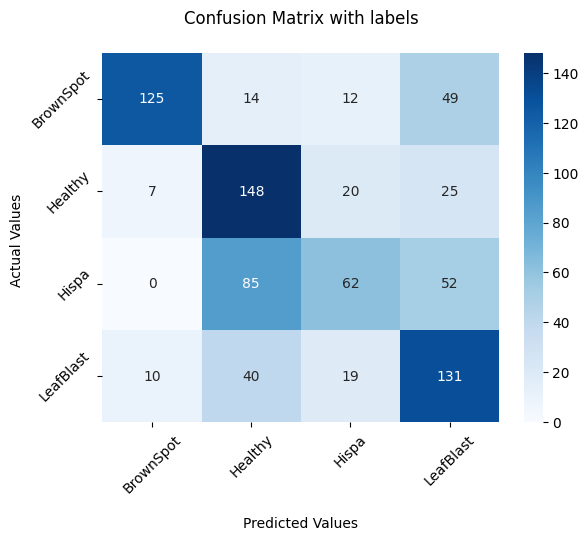

In [40]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

plt.show()

In [41]:
model = keras.models.load_model('/content/Model_MobileNetV2.h5')

In [42]:
save_model("MobileNetV2-0.58val", model, "/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Rice/Model")

Export path:  /content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Rice/Model/MobileNetV2-0.58val
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']
